# Grover's search algorithm

In this notebook, we will implement Grover's search algorithm.

## Example studied

We will look for the number 5 which can be stored on 3 bits.

We will implement the oracle $U_f$:
* with Z gates on 3 qubits
* with CNOT gates on 4 qubits

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from math import pi, floor, sqrt

In [2]:
provider = IBMQ.load_account()

## Define new gates

We need to build some new gates to later implement $U_f$ and $U_s$, namely CCZ and CCCNOT.

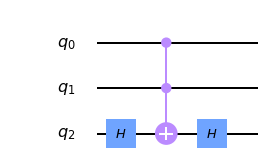

In [3]:
# Here we define the ccz gate not with 2 Toffoli and 1 cZ
# but with 2 H and 1 Toffoli (without ancilla qubit)
ccz = QuantumCircuit(3, name='CCZ')
ccz.h(2)
ccz.toffoli(0, 1, 2)
ccz.h(2)

ccz.draw()

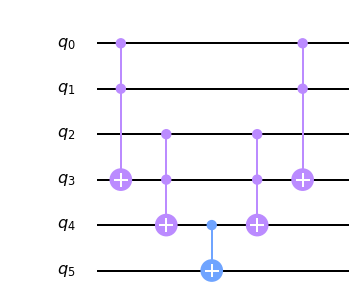

In [4]:
# Here we use the technique presented in the report to define a cccnot gate
# This technique uses 2 more ancilla qubit (numbered 3 and 4 here)
# 6 is to ancilla qubit of the algorithm
cccnot = QuantumCircuit(6, name='CCCNOT')
cccnot.toffoli(0, 1, 3)
cccnot.toffoli(2, 3, 4)
cccnot.cnot(4, 5)
cccnot.toffoli(2, 3, 4)
cccnot.toffoli(0, 1, 3)

cccnot.draw()

## Define oracles

Here, we will build the two versions of $U_f$, one with CCZ and the other one with CCCNOT.

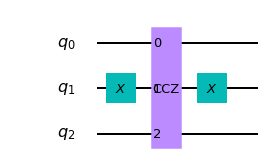

In [5]:
# We use the implementation described in the report
uf_with_z = QuantumCircuit(3, name='Uf_z')
uf_with_z.x(1)
uf_with_z.append(ccz.to_instruction(), range(3))
uf_with_z.x(1)

uf_with_z.draw()


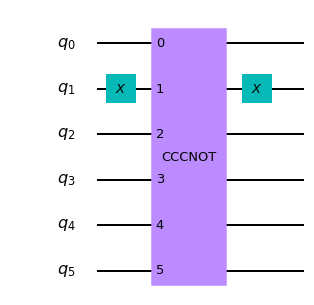

In [6]:
# The implementation of the report
uf_with_not = QuantumCircuit(6, name='Uf_not')
uf_with_not.x(1)
uf_with_not.append(cccnot.to_instruction(), range(6))
uf_with_not.x(1)

uf_with_not.draw()

## Define Grover's spread operator

Now that we have $U_f$, we can implement $U_s$.

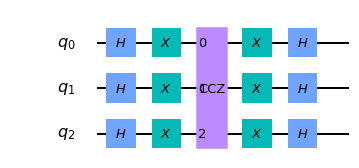

In [7]:
# Implementation of the report
us = QuantumCircuit(3, name='Us')
us.h(range(3))
us.x(range(3))
us.append(ccz.to_instruction(), range(3))
us.x(range(3))
us.h(range(3))

us.draw()

## Implement the algorithm

We now have all the necessary building blocks to construct the circuit.

We will actually build two circuit, one using $U_f$ with a Z gate and another one using $U_f$ with a CNOT gate.

In [8]:
def build_grover_circuit(oracle: QuantumCircuit, ancilla: bool = False) -> QuantumCircuit:
    """
    Function to build a circuit implementing Grover's algorithm given an oracle Uf.
    
    :param oracle: the oracle Uf to put in the circuit
    :param ancilla: True if the circuit has an ancilla qubit that must be initialized to |1>
    """
    nb_qubits = oracle.n_qubits
    circuit = QuantumCircuit(nb_qubits, nb_qubits)
    if(ancilla):
        circuit.x(nb_qubits - 1)
        circuit.h(nb_qubits - 1)
    circuit.h(range(3))
    for i in range(floor(pi/4 * sqrt(2**nb_qubits))):
        circuit.append(oracle.to_instruction(), range(nb_qubits))
        circuit.append(us.to_instruction(), range(3))
    circuit.measure(range(3), range(3))
    return circuit

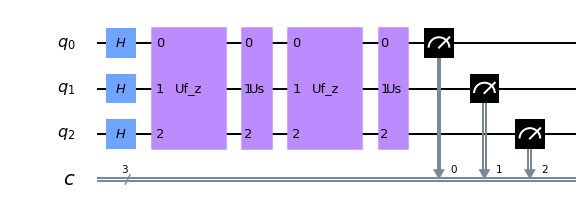

In [9]:
circuit_z = build_grover_circuit(uf_with_z)
circuit_z.draw()

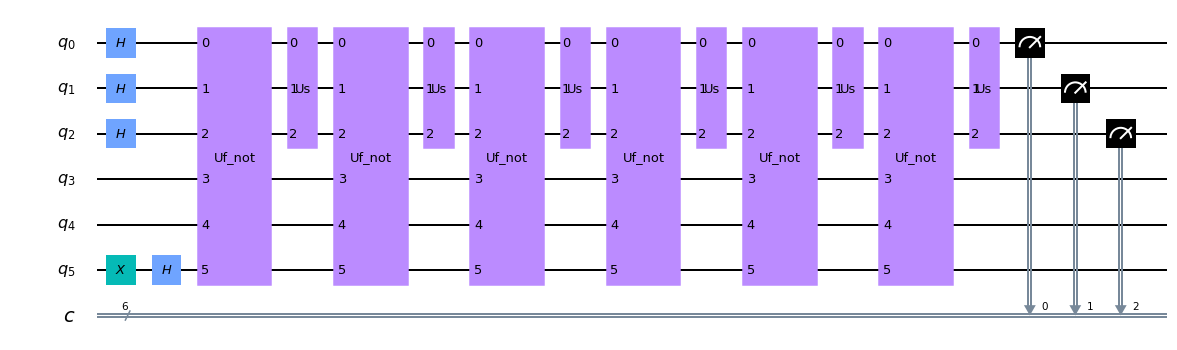

In [10]:
circuit_not = build_grover_circuit(uf_with_not, True)
circuit_not.draw()

## Simulation of the circuits

It is time to simulate the circuits we built.

In [11]:
# Simulate the first one
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator') # get the backend (here, a simulator)
    job = execute(circuit, backend=simulator, shots=1024) # run 1024 time the circuit on it
    return job.result().get_counts(circuit)

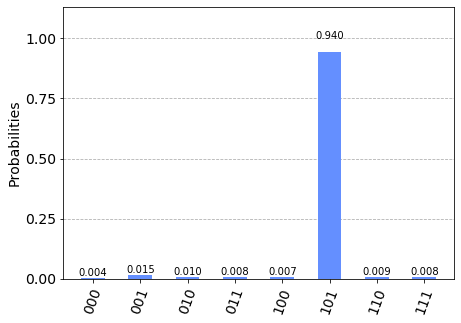

In [12]:
# First the circuit with Z
plot_histogram(simulate(circuit_z))

As expected, the probability of measuring the pure state |101> is very high.
But this probability is not equal to 1 because Grover's algorithm is not deterministic, it only increases the probability of a state to be measured.

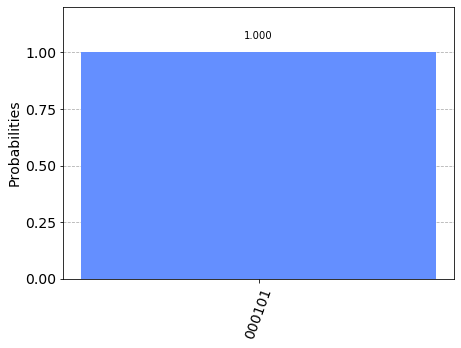

In [13]:
# Simulate the second circuit with NOT
plot_histogram(simulate(circuit_not))

## Run a circuit on a real device

Even if the simulated results are noisy, in the case of the first circuit with a Z gate, they are still good enough and it should be worth running it on a real quantum computer.

In [14]:
device = least_busy(provider.backends(filters=lambda b: not b.configuration().simulator
                                              and b.status().operational
                                              and b.configuration().n_qubits >= circuit_z.n_qubits))
print(device)

ibmq_ourense


In [15]:
job = execute(circuit_z, backend=device, shots=1024)
job_monitor(job)

Job Status: job has successfully run


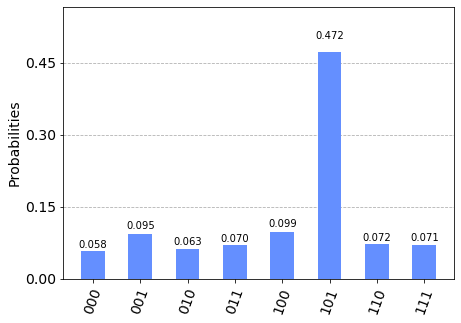

In [16]:
counts = job.result().get_counts()
plot_histogram(counts)

The results are even more noisy than those simulated.

Let us try to mitigate the noise with Qiskit Ignis.

In [17]:
# Calibration of the device
calibration_circuits, state_labels = complete_meas_cal(qubit_list=range(circuit_z.n_qubits), circlabel='measurement_calibration')
calibration_jobs = execute(calibration_circuits, backend=device, shots=1024*4, optimization_level=0)
job_monitor(calibration_jobs)
calibration_results = calibration_jobs.result()
measurement_fitter = CompleteMeasFitter(calibration_results, state_labels)
measurement_filter = measurement_fitter.filter

Job Status: job has successfully run


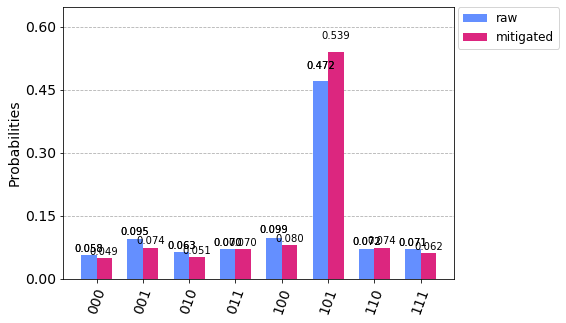

In [18]:
# Mitigate the noise according to the calibration
mitigated_result = measurement_filter.apply(job.result())
mitigated_counts = mitigated_result.get_counts(circuit_z)

plot_histogram([counts, mitigated_counts], legend=['raw', 'mitigated'])

Mitigated results are slightly better.
The pure state |101> is still the most frequent state measured.

## Conclusion

We saw two ways to implement Grover's algorithm to look for the pure state |101>.
The first one uses a Z gate.
The second one uses a CNOT gate but requires an ancilla qubit.

Furthermore, we saw a way to implement an CCCNOT gate but this way uses ancilla qubits.

We highlighted the fact that Grover's algorithm is not deterministic.
It has a high probability to give the correct output but it can also give a wrong answer.

One last thing to mention is that these circuits are only examples to familiarize with Grover's algorithm.
First, because we do not need to re-implement ourselves a CCCNOT gate since Qiskit already provides a function to do so in the Aqua module called `mct(q_controls, q_target, q_ancilla, mode)` (more information [here](https://qiskit.org/documentation/api/qiskit.aqua.circuits.gates.mct.html)).
Then, because Grover's algorithm is itself already implemented in Qiskit in the Aqua module ([here](https://qiskit.org/documentation/apidoc/aqua/algorithms/algorithms.html?highlight=grover#qiskit.aqua.algorithms.Grover)).